In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
import openai
import cv2,os
import sys
import argparse
sys.path.append('../../../')
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent
from models.utils.gpt_helper import (GPT4VisionClass,printmd, response_to_json, parse_and_get_action,
                                     extract_arguments, match_objects, decode_image)
print ("openai version:[%s]"%(openai.__version__))

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')


openai version:[1.3.8]


In [2]:
#%%
parser = argparse.ArgumentParser(description='EXP1-Rationale: Interaction Accuracy, Preference Accuracy')
parser.add_argument('--save_path', type=str, default='./results/', help='Save path')
parser.add_argument('--gpt_model', type=str, default='gpt-4-vision-preview', choices=['gpt-4-vision-preview', 'gpt-4', 'gpt-3.5-turbo'], help='Select GPT model')
args = parser.parse_args(args=[])

In [3]:
# 1. Start with Image description
model = GPT4VisionClass(key_path='../../../key/rilab_key.txt', max_tokens=2056, temperature=0.9,
    gpt_model="gpt-4-vision-preview",
    role_msg="You are a helpful agent with vision capabilities; do not respond to objects not depicted in images."
    )

# 2. System prompt: functions, object_names
print("\033[94m [System prompt: infrom the format of the answer] \033[0m")


key_path:[../../../key/rilab_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

 [System prompt: infrom the format of the answer] 


### Get `preference weight` based on `feature function`

In [4]:
import numpy as np

def unnormalize_position(position, table_position, table_size):
    '''
    Unnormalize the position of the object.

    Args:
    position (np.array): Normalized position (x, y) of the object on the table.
    table_position (np.array): Position (x, y, z) of the table in the space.
    table_size (np.array): Size (width, length) of the table.

    Returns:
    np.array: Unnormalized position (x, y, z) of the object in the space.
    '''

    # Scale the normalized position by the size of the table
    # scaled_position = position[:2] * table_size
    scaled_position = position[:2] * np.array([-table_size[0]/2, table_size[1]/2])

    # Offset the scaled position by the x and y coordinates of the table's position
    unnormalized_position = np.array([
        scaled_position[0] + table_position[0], 
        scaled_position[1] + table_position[1], 
        table_position[2]  # The z-coordinate is the same as the table's z-coordinate
    ])

    return unnormalized_position

# Assuming the provided data structure and the existing function to unnormalize positions
def unnormalize_positions_for_all_images(images_data, table_position, table_size):
    all_unnormalized_positions = []

    for image_data in images_data["images"]:
        normalized_positions_dict = image_data['normalized_positions'][0]

        unnormalized_positions = {obj: unnormalize_position(np.array(pos), table_position, table_size) 
                                  for obj, pos in normalized_positions_dict.items()}
        
        all_unnormalized_positions.append({
            "image_idx": image_data['image_idx'],
            "unnormalized_positions": unnormalized_positions
        })

    return all_unnormalized_positions

functions_text = """
import numpy as np

def parse_color_shape(obj_name):
    '''
        Parse color and shape from object name
    '''
    parts = obj_name.split('_')
    return parts[2], parts[1]  # (color, shape)

def calculate_distance(coord1, coord2):
    '''
        Calculate the distance between two coordinates
    '''
    return np.linalg.norm(coord1 - coord2)

def normalize(value, min_value, max_value):
    '''
        Normalize a value between 0 and 1
    '''
    return (value - min_value) / (max_value - min_value)

def unnormalize_position(position, table_position, table_size):
    '''
    Unnormalize the position of the object.

    Args:
    position (np.array): Normalized position (x, y) of the object on the table.
    table_position (np.array): Position (x, y, z) of the table in the space.
    table_size (np.array): Size (width, length) of the table.

    Returns:
    np.array: Unnormalized position (x, y, z) of the object in the space.
    '''

    # Scale the normalized position by the size of the table
    # scaled_position = position[:2] * table_size
    scaled_position = position[:2] * np.array([-table_size[0]/2, table_size[1]/2])

    # Offset the scaled position by the x and y coordinates of the table's position
    unnormalized_position = np.array([
        scaled_position[0] + table_position[0], 
        scaled_position[1] + table_position[1], 
        table_position[2]  # The z-coordinate is the same as the table's z-coordinate
    ])

    return unnormalized_position

# Assuming the provided data structure and the existing function to unnormalize positions
def unnormalize_positions_for_all_images(images_data, table_position, table_size):
    all_unnormalized_positions = []

    for image_data in images_data["images"]:
        normalized_positions_dict = image_data['normalized_positions'][0]

        unnormalized_positions = {obj: unnormalize_position(np.array(pos), table_position, table_size) 
                                  for obj, pos in normalized_positions_dict.items()}
        
        all_unnormalized_positions.append({
            "image_idx": image_data['image_idx'],
            "unnormalized_positions": unnormalized_positions
        })

    return all_unnormalized_positions

# Rule: The table position and size are fixed
# table_position = np.array([0.68, 0.0, 0.74])
# table_size = np.array([0.4, 0.4])

Here is example code for calculating the weights in an image:
import numpy as np

def calculate_weights(positions, table_position, table_size):
    '''
    Calculate the weights of the objects in the image based on their positions.

    Args:
    positions (dict): Dictionary of object names and their positions.
    table_position (np.array): Position (x, y, z) of the table in the space.
    table_size (np.array): Size (width, length) of the table.

    Returns:
    dict: Dictionary of object names and their weights.
    '''
    # Calculate the distance of each object from the center of the table
    distances = {obj: calculate_distance(pos, table_position) for obj, pos in positions.items()}

    # Normalize the distances between 0 and 1
    min_dist = np.min(list(distances.values()))
    max_dist = np.max(list(distances.values()))
    normalized_distances = {obj: normalize(dist, min_dist, max_dist) for obj, dist in distances.items()}

    # Calculate the weights of the objects based on their normalized distances
    weights = {obj: 1 - dist for obj, dist in normalized_distances.items()}

    return weights

def calculate_preferences(normalized_positions_data):
    '''
    Calculate the preference of the objects in the image based on their positions.
    This reward function computes the weights between the image sequences.
    It calculates a preference_weight based on the unnormalized position values, normalized by agent. 
    The total reward is the preference.

    Args:
    positions (dict): Dictionary of object names and their positions.
    table_position (np.array): Position (x, y, z) of the table in the space.
    table_size (np.array): Size (width, length) of the table.

    Returns:
    dict: Dictionary of object names and their preferences.
    '''
    preference_values = []

    for image in normalized_positions_data['images']:
        image_idx = image['image_idx']
        positions = image['normalized_positions'][0]

        w_rearrange_shape = <calculate the weight of rearranging objects with the same shape>
        w_stack_with_same_color = <calculate the weight of stacking objects with the same color>

        w_stack_with_same_shape = <calculate the weight of stacking objects with the same shape>

        preference_values.append({
            'image_idx': image_idx,
            'preferences': [w_rearrange_shape, w_stack_with_same_color, w_stack_with_same_shape]
        })
    return preference_values
    
# Normalized positions are given as a dictionary.
unnormalized_positions = {obj: unnormalize_position(pos, table_position, table_size) 
                          for obj, pos in normalized_positions.items()}

# Calculate the preference of the objects
preferences = calculate_preference(unnormalized_positions, table_position, table_size)

'''
Like the previous example, you could make new functions and use them in your response.
You could also use the functions that you have already defined.
Response ONLY for executable python code.
Fill the function: <calculate_weights>, <calculate_preferences>. Given example is just a sample so you should change it.
Please do not add any other texts in your response.
If you understand this template, say YES.
'''
"""

In [5]:
import numpy as np

def parse_color_shape(obj_name):
    '''
        Parse color and shape from object name
    '''
    parts = obj_name.split('_')
    return parts[2], parts[1]  # (color, shape)

def calculate_distance(coord1, coord2):
    '''
        Calculate the distance between two coordinates
    '''
    return np.linalg.norm(coord1 - coord2)

def calculate_distance(coord1, coord2):
    '''
        Calculate the distance between two coordinates
    '''
    return np.linalg.norm(coord1 - coord2)

def normalize(value, min_value, max_value):
    '''
        Normalize a value between 0 and 1
    '''
    return (value - min_value) / (max_value - min_value)

['17', '18', '33', '34', '62', '63', '76', '82', '96', '102', '103', '107', '120', '121', '131', '136', '155', '160', '164', '173', '174', '177']
22


DETAIL: high

[0/5] image_path: ../../dataset/block-and-bowl-scene/shape/17/scene_img_0.png
[1/5] image_path: ../../dataset/block-and-bowl-scene/shape/17/scene_img_1.png
[2/5] image_path: ../../dataset/block-and-bowl-scene/shape/17/scene_img_2.png
[3/5] image_path: ../../dataset/block-and-bowl-scene/shape/17/scene_img_3.png
[4/5] image_path: ../../dataset/block-and-bowl-scene/shape/17/scene_img_4.png


[VISUALIZE]

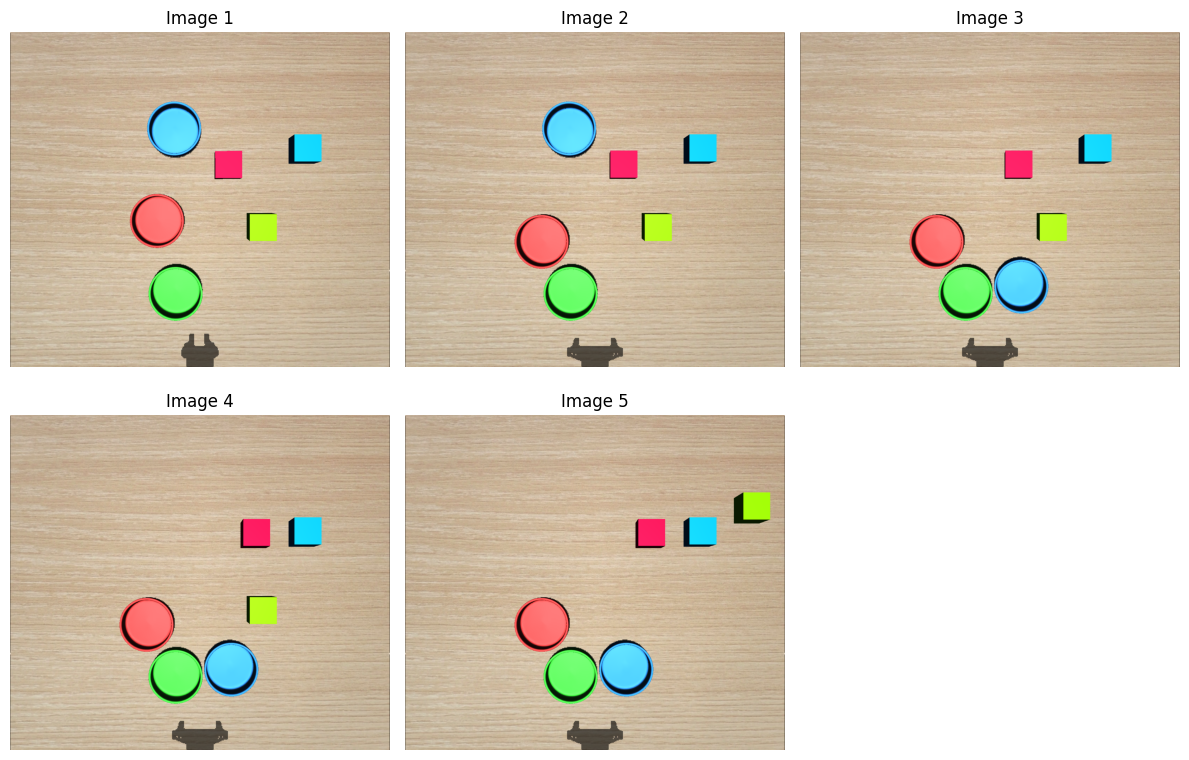

In [6]:
#%%
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import openai
import argparse

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')

interaction_accuracy_list = []
preference_list = []
token_list = []
image_token_list = []
response_error_count = 0
python_code_list = []

#%%
objective = 'shape'
dataset_path = '../../dataset/block-and-bowl-scene/'
path = os.path.join(dataset_path, objective)
# path = '../../dataset/block-and-bowl-scene/stack/'
# path = '../../dataset/block-and-bowl-scene/shape/'
folders = sorted(os.listdir(path), key=lambda x: int(x.split('.')[0]))
print(folders)
print(len(folders))

object_names = ["obj_box_red_01", "obj_box_blue_01", "obj_box_green_01", 
                "obj_bowl_red", "obj_bowl_blue", "obj_bowl_green"]

query_positions_text = """
You need to extract the object's positions from the image. object_names: ["obj_box_red_01", "obj_box_blue_01", "obj_box_green_01", "obj_bowl_red", "obj_bowl_blue", "obj_bowl_green"]
Response for each object's positions in normalized scales. (z-axis value is all the same as 0,5)
IMPORTANT: Center of the image (Table) is [x,y,z] = [0.5, 0.5, 0.5] (in normalized scale)
# In the image, the direction from the right to the left is the positive y-axis, and the direction from the bottom to the top is the positive x-axis.
# Carefully check the coordinate system of the image.

- x: [0.0, 1.0]
- y: [0.0, 1.0]
- z: [0.5]

Format:
{
    "images": [
        "image_idx": <image_idx>,
        "normalized_positions": 
            [
                {
                "obj_box_red_01": [<x>, <y>, <z>],
                "obj_box_blue_01": [<x>, <y>, <z>],
                "obj_box_green_01": [<x>, <y>, <z>],
                "obj_bowl_red": [<x>, <y>, <z>],
                "obj_bowl_blue": [<x>, <y>, <z>],
                "obj_bowl_green": [<x>, <y>, <z>]
                }
        (... repeat for the number of images ...)
            ]
    ]
}

# Note: Replace <x>, <y>, <z> with the normalized values.
# Do not add any other texts in your response.
# If you don't know the positions, fill in the values with 0.5.
# The origin is the center of the image.
# You should respond object's positions to all of images.

Here is the example of the response:
"""

for folder_idx, folder in enumerate(folders):
    # Reset the chat for each evaluation
    model._backup_chat()
    model.messages = model.init_messages
    ######################################
    interaction_accuracy = None
    preference_accuracy = None

    images = []
    color_folder_path = os.path.join(path, folder)
    # Filter filenames that start with 'rgb_'
    # rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('rgb_')]
    rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('scene_')]    # TOP-VIEW IMAGES
    interaction_info_path = [f for f in os.listdir(color_folder_path) if f.startswith('interaction_info')]
    # Sort it with ends_with number
    sorted_rgb_filenames = sorted(rgb_filenames, key=extract_number)
    # print(sorted_rgb_filenames)
    for rgb_index, sorted_rgb in enumerate(sorted_rgb_filenames):
        path_local = os.path.join(color_folder_path, sorted_rgb)
        images.append(path_local)

    
    response_interaction = model.chat(query_text=query_positions_text, image_paths=images, images=[],
                                PRINT_USER_MSG=True,
                                PRINT_GPT_OUTPUT=True,
                                RESET_CHAT=False,
                                RETURN_RESPONSE=True,
                                VISUALIZE=True,
                                DETAIL='high',
                                CROP=(280, 0, 1920-280, 1200))
    response_interaction_json, error_message = response_to_json(response_interaction)
    # Table specification
    table_position = np.array([0.68, 0.0, 0.74])
    table_size = np.array([0.4, 0.4])  # width, length
    normalized_positions = response_interaction_json

    # Unnormalize the positions
    unnormalized_data = unnormalize_positions_for_all_images(response_interaction_json, table_position, table_size)
    print("###### unnormalized_data ######")
    print(unnormalized_data)
    print("###############################")

    query_preference_text = f"""
    Based on the input image and normalized positions for each image, give me python code to determine the preference of object rearrangement.
    - normalized_positions: {normalized_positions}
    Answer preferences solely based on the calculated each preference values.

    Preference is defined as follows:
    - w_rearrange_shape: Rearrange the objects with same shapes in plane.
    - w_stack_with_same_color: Stack the objects with same colors.
    - w_stack_with_same_shape: Stack the objects with same shapes.

    Response ONLY for executable python code without any other additional modifications.
    Please do not add any other texts in your response.
    End codes with print for each preference values [w_rearrange_shape_in_plane, w_stack_with_same_color, w_stack_with_same_shape] and determine the maximum preference value and name of the preference: result_preference = [max_preference_value, max_preference_name].
    # rearrange in plane: rearrange the objects with same shapes in plane.
    # stack with same color: stack the objects with same colors.
    # stack with same shape: stack the objects with same shapes.
    """

    response_code_snippet = model.chat(query_text=query_preference_text, image_paths=None, images=None,
                                PRINT_USER_MSG=True,
                                PRINT_GPT_OUTPUT=True,
                                RESET_CHAT=False,
                                RETURN_RESPONSE=True,
                                VISUALIZE=True,
                                DETAIL='high',
                                CROP=(280, 0, 1920-280, 1200))
    # Extract the Python code
    pattern = "```python(.*?)```"
    match = re.search(pattern, response_code_snippet, re.DOTALL)

    if match:
        python_code = match.group(1).strip()
        python_code_list.append(python_code)
        try: # executing the code
            exec_globals = {}
            exec(python_code)
            result_preference = exec_globals["result_preference"]
            preference_list.append(result_preference)
            print(f"result_preference: {result_preference}")
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print("Python code not found.")

    if folder_idx > 10:
        print("Evaluation is done.")
        break

In [ ]:
# save preference_list
if not os.path.exists(os.path.join(args.save_path,objective)):
    os.makedirs(os.path.join(args.save_path,objective))
np.save(os.path.join(args.save_path,objective,f'python_code_{objective}.npy'), python_code_list)

In [ ]:
len(python_code_list)

14

In [ ]:
python_code_list[0]

'import numpy as np\n\n# Define the normalized positions for the images\nnormalized_positions = {\n    \'images\': [\n        {\'image_idx\': 1, \'normalized_positions\': [\n            {\'obj_box_red_01\': [0.7, 0.7, 0.5], \'obj_box_blue_01\': [0.75, 0.55, 0.5], \'obj_box_green_01\': [0.75, 0.8, 0.5],\n             \'obj_bowl_red\': [0.3, 0.3, 0.5], \'obj_bowl_blue\': [0.3, 0.55, 0.5], \'obj_bowl_green\': [0.3, 0.7, 0.5]}\n        ]},\n        {\'image_idx\': 2, \'normalized_positions\': [\n            {\'obj_box_red_01\': [0.7, 0.7, 0.5], \'obj_box_blue_01\': [0.75, 0.55, 0.5], \'obj_box_green_01\': [0.75, 0.8, 0.5],\n             \'obj_bowl_red\': [0.3, 0.3, 0.5], \'obj_bowl_blue\': [0.3, 0.55, 0.5], \'obj_bowl_green\': [0.3, 0.8, 0.5]}\n        ]},\n        {\'image_idx\': 3, \'normalized_positions\': [\n            {\'obj_box_red_01\': [0.7, 0.7, 0.5], \'obj_box_blue_01\': [0.75, 0.55, 0.5], \'obj_box_green_01\': [0.75, 0.8, 0.5],\n             \'obj_bowl_red\': [0.3, 0.3, 0.5], \

In [ ]:
for code_idx, python_code in enumerate(python_code_list):
    if code_idx==8 or code_idx==9:
        continue
    print(f"################## {code_idx} ##################")
    exec(python_code)
    print("###############################################")


################## 0 ##################
w_rearrange_shape: 0.7633471196860986
w_stack_with_same_color: 0.5096086545394799
w_stack_with_same_shape: 1.0
result_preference: [1.0, 'w_stack_with_same_shape']
###############################################
################## 1 ##################
[0.8000000000000002, 1.5031533525193297, 1.0901141309584341]
[1.5031533525193297, 'w_stack_with_same_color']
###############################################
################## 2 ##################
[0.5960573106066287, 0.5586340223600578, 0]
[0.5960573106066287, 'w_rearrange_shape']
###############################################
################## 3 ##################
Preferences: [13.6, 5.9, 24.0]
Maximum Preference: [24.0, 'w_stack_with_same_shape']
###############################################
################## 4 ##################
0 0 0
[0, 'w_rearrange_shape']
###############################################
################## 5 ##################
[0.977628523081755, 1.5079894955027642, 1.7301

KeyError: 'obj_bowl_red_01'

In [ ]:
exec(python_code_list[9])

ValueError: too many values to unpack (expected 3)

In [ ]:
exec(python_code_list[2])

w_rearrange_shape: 0, w_stack_with_same_color: 0, w_stack_with_same_shape: 0
[0, 'w_rearrange_shape']


In [ ]:
import numpy as np

# Given normalized positions for each image
normalized_positions = {
    'images': [
        {'image_idx': 1, 'normalized_positions': [
            {'obj_box_red_01': [0.675, 0.3, 0.5], 'obj_box_blue_01': [0.725, 0.45, 0.5], 'obj_box_green_01': [0.775, 0.45, 0.5],
             'obj_bowl_red': [0.225, 0.2, 0.5], 'obj_bowl_blue': [0.275, 0.55, 0.5], 'obj_bowl_green': [0.225, 0.6, 0.5]}],
        },
        # Add the rest of the image positions as needed...
    ]
}

# Initialize preference weights
w_rearrange_shape = 0
w_stack_with_same_color = 0
w_stack_with_same_shape = 0

# Calculate the preferences based on object positions
for image in normalized_positions['images']:
    positions = image['normalized_positions'][0]
    # Calculate rearrange shape preference
    for color in ['red', 'blue', 'green']:
        box = positions[f'obj_box_{color}_01']
        bowl = positions[f'obj_bowl_{color}']
        w_rearrange_shape += np.linalg.norm(np.subtract(box[:2], bowl[:2]))

    # Calculate stack with same color preference
    for shape in ['box']:
        red = positions[f'obj_{shape}_red_01']
        blue = positions[f'obj_{shape}_blue_01']
        green = positions[f'obj_{shape}_green_01']
        w_stack_with_same_color += (np.linalg.norm(np.subtract(red[:2], blue[:2])) +
                                    np.linalg.norm(np.subtract(red[:2], green[:2])) +
                                    np.linalg.norm(np.subtract(blue[:2], green[:2])))
    for shape in ['bowl']:
        red = positions[f'obj_{shape}_red']
        blue = positions[f'obj_{shape}_blue']
        green = positions[f'obj_{shape}_green']
        w_stack_with_same_color += (np.linalg.norm(np.subtract(red[:2], blue[:2])) +
                                    np.linalg.norm(np.subtract(red[:2], green[:2])) +
                                    np.linalg.norm(np.subtract(blue[:2], green[:2])))
    # Calculate stack with same shape preference
    for obj in positions.keys():
        if 'box' in obj:
            other_shape = obj.replace('box', 'bowl')
            w_stack_with_same_shape += np.linalg.norm(np.subtract(positions[obj][:2], positions[other_shape][:2]))

# Normalize the preferences based on the number of images
num_images = len(normalized_positions['images'])
w_rearrange_shape /= num_images
w_stack_with_same_color /= num_images
w_stack_with_same_shape /= num_images

# Print each preference value
print(f'w_rearrange_shape: {w_rearrange_shape}')
print(f'w_stack_with_same_color: {w_stack_with_same_color}')
print(f'w_stack_with_same_shape: {w_stack_with_same_shape}')

# Determine the maximum preference value and name
preferences = {
    'w_rearrange_shape': w_rearrange_shape,
    'w_stack_with_same_color': w_stack_with_same_color,
    'w_stack_with_same_shape': w_stack_with_same_shape
}

max_preference_value = max(preferences.values())
max_preference_name = max(preferences, key=preferences.get)
result_preference = [max_preference_value, max_preference_name]

# Print the result preference
print(f'result_preference: {result_preference}')

KeyError: 'obj_bowl_red_01'